<a href="https://colab.research.google.com/github/elliwadler/image_classification/blob/main/cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotheken importieren


In [2]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


import urllib.request
import zipfile
import gdown


## Ressourcen laden

Der Code lädt einen **Datensatz** mit Hund- und Katzenbildern als ZIP-Datei herunter und extrahiert ihn in zwei Ordner, "train" und "validation", die für das Training und die Validierung des **CNN-Modells** (Convolutional Neural Networks) zur Klassifikation von Hund- und Katzenbildern verwendet werden.

In [3]:
# Download the dataset zip file
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
filename = "cats_and_dogs_filtered.zip"
urllib.request.urlretrieve(url, filename)

# Extract the zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()



## Vorbereitung der Daten 

Um die Daten für das Modell Vorzubereiten wird die **ImageDataGenerator-Klasse** aus der Keras-API verwendet. In dieser werden Datenaugmentierungstechniken wie Drehung, Zuschneiden oder Spiegeln definiert um sie auf die Bilder anzuwenden.

Anschließend wird mit der **flow_from_directory()-Methode** ein **Generator-Objekt** erzeugt, das später an das Modell übergeben wird. Dabei werden unter anderem das Verzeichnis aus dem die Bilder geladen werden, die Bildgröße, die Batch-Größe und die Label-Art (in diesem Fall binary, also entweder Hund oder Katze) definiert.


In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# no argumentation only: image data is scaled to the range of 0 to 1 by dividing each pixel value by 255. 
# common practice in image processing to ensure that the pixel values are in a suitable range for processing by the model.
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'cats_and_dogs_filtered/train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        'cats_and_dogs_filtered/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## *Beispiel Augementierung eines Bildes*

Hier wird die ImageDataGenerator-Instanz **train_datagen** verwendet um die Argumentation eines Beispielbildes zu veranschaulichen. 





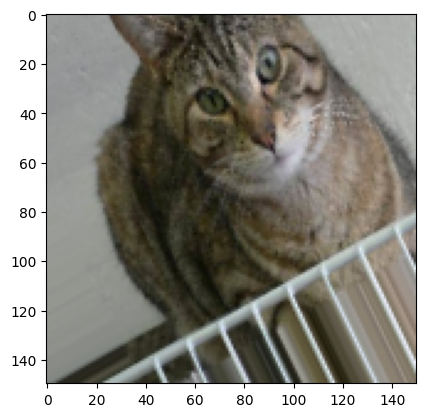

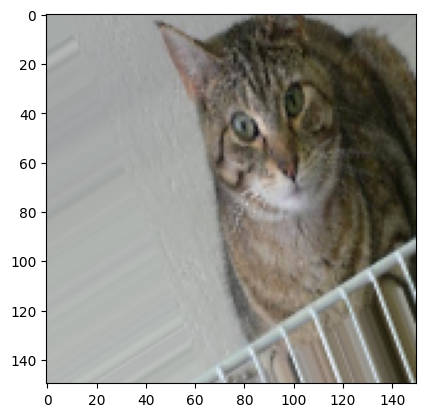

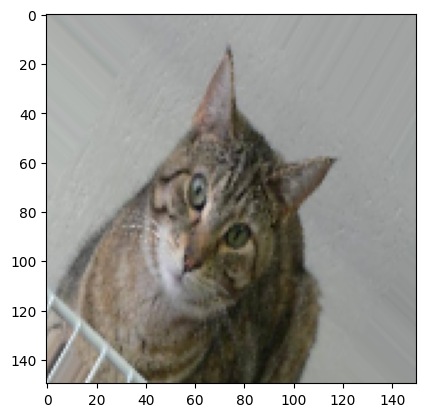

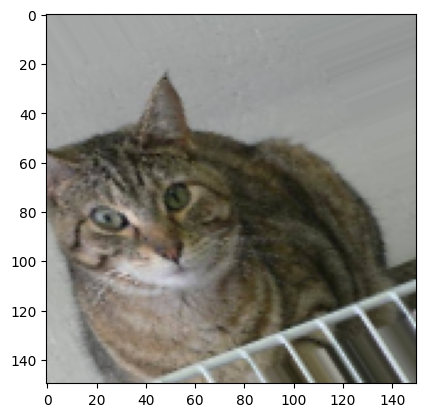

In [6]:
# get all files from the train/cat directory
fnames = [os.path.join('cats_and_dogs_filtered/train/cats', fname) for
  fname in os.listdir('cats_and_dogs_filtered/train/cats')]

# get one picture
img_path = fnames[6]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# plot the result
i=0
for batch in train_datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break
plt.show()

## Definition des Modells

In Keras ist das **Sequential-Modell** eine Möglichkeit, um Schichten eines neuronalen Netzwerks aufeinander zu stapeln. Das bedeutet, dass die Ausgabe einer Schicht direkt an die nächste Schicht weitergegeben wird. Ein Sequential-Modell ist somit eine lineare Schichtfolge, bei der jede Schicht genau eine Eingabe und eine Ausgabe hat. Dies ist die einfachste Art, ein neuronales Netzwerk in Keras zu definieren. Die einzelnen Schichtarten werden in der **README ausführlich** erklärt!

Im nächsten Schritt wird der **Kompilierungsschritt** des Modells konfiguriert. Auf die einzelnen Werte wird wieder in der README eingeganen. 




In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.15),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer= tf.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# shows each layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Trainieren des Modells

In diesem Code-Abschnitt wird das Modell auf den Trainingsdaten **trainiert** und dabei eine **Validierung** anhand der Validierungsdaten durchgeführt. Die Trainingsdaten und die Validierungsdaten wurden zuvor als Daten-Generator mit der Klasse **ImageDataGenerator** erstellt und werden nun als **Argumente** an die fit-Methode des Modells übergeben.

**Parameter:**

**steps_per_epoch**: gibt die Anzahl der Schritte pro Epoche an, d.h. die Anzahl der Batches, die pro Epoche durchlaufen werden sollen. 

**epochs:** gibt die Anzahl der Epochen an, die das Modell trainiert werden soll. 

**validation_steps:**  Anzahl der Schritte (Batches), die pro Validierungs-Epoche durchlaufen werden sollen. 

Die fit-Methode führt das Training des Modells durch und gibt ein **history-Objekt zurück**, das die Informationen über die Trainingsgenauigkeit, Trainingsverlust, Validierungsgenauigkeit und Validierungsverlust in jeder Epoche enthält.

**Da das Trainieren das Modells den heutigen Zeitraum sprengen würde werden wir das ein zuvor von mir trainiertes Modell in den weiteren Schritten verwenden**!

In [9]:
''' history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50) '''


# load pretrained model
gdown.download_folder('https://drive.google.com/drive/folders/1MPrC5o7rI8_EYEZ6TLOWsWes44JKk-aD?usp=sharing')

Retrieving folder list


Processing file 1nAudCTyHuYbRz2OVgTXrs_Q3IlxeNY_j cats_dogs_classifier_80%.h5
Processing file 1-2L7gC6AgzBoKHlBbpGhZ82PlI_n6Wza model.zip
Processing file 1-C0riND-ldiGV6ecyYmZThenI1A1958V train_history_80%.csv
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1nAudCTyHuYbRz2OVgTXrs_Q3IlxeNY_j
To: c:\Users\ellil\OneDrive\Dokumente\SS23\SEMMSD\image_classification\image_classification\Assets_Modell\cats_dogs_classifier_80%.h5
100%|██████████| 27.7M/27.7M [00:11<00:00, 2.33MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-2L7gC6AgzBoKHlBbpGhZ82PlI_n6Wza
To: c:\Users\ellil\OneDrive\Dokumente\SS23\SEMMSD\image_classification\image_classification\Assets_Modell\model.zip
100%|██████████| 25.6M/25.6M [00:08<00:00, 2.96MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-C0riND-ldiGV6ecyYmZThenI1A1958V
To: c:\Users\ellil\OneDrive\Dokumente\SS23\SEMMSD\image_classification\image_classification\Assets_Modell\train_history_80%.csv
100%|██████████| 7.60k/7.60k [00:00<00:00, 2.68MB/s]
Download completed


['c:\\Users\\ellil\\OneDrive\\Dokumente\\SS23\\SEMMSD\\image_classification\\image_classification\\Assets_Modell\\cats_dogs_classifier_80%.h5',
 'c:\\Users\\ellil\\OneDrive\\Dokumente\\SS23\\SEMMSD\\image_classification\\image_classification\\Assets_Modell\\model.zip',
 'c:\\Users\\ellil\\OneDrive\\Dokumente\\SS23\\SEMMSD\\image_classification\\image_classification\\Assets_Modell\\train_history_80%.csv']

## Validierung des Modells

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 7s 134ms/step


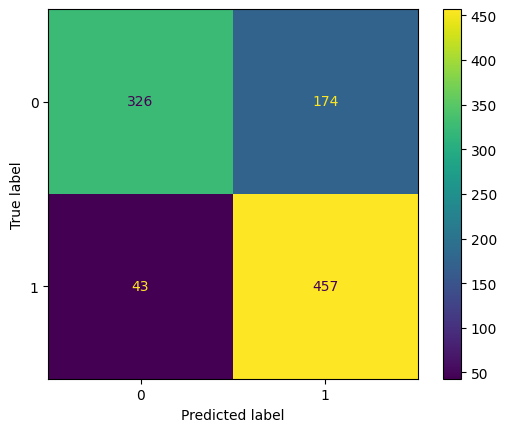

In [10]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the saved model
model = load_model('Assets_Modell/cats_dogs_classifier_80%.h5')

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a DirectoryIterator for the test data
test_dir = 'cats_and_dogs_filtered/validation'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        shuffle = False)

# Get the predicted classes for the test data
y_pred_prob = model.predict(test_generator)
y_pred = np.round(y_pred_prob)

# Get the true classes for the test data
y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
cm_display = ConfusionMatrixDisplay(cm).plot()

50/50 [==============================] - 4s 71ms/step - loss: 0.4581 - acc: 0.7850
Test accuracy: 0.7850000262260437


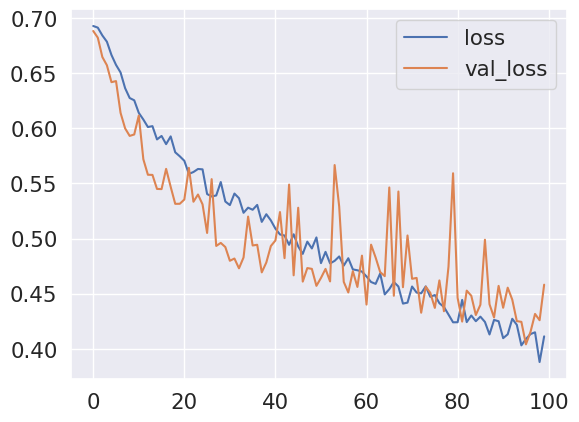

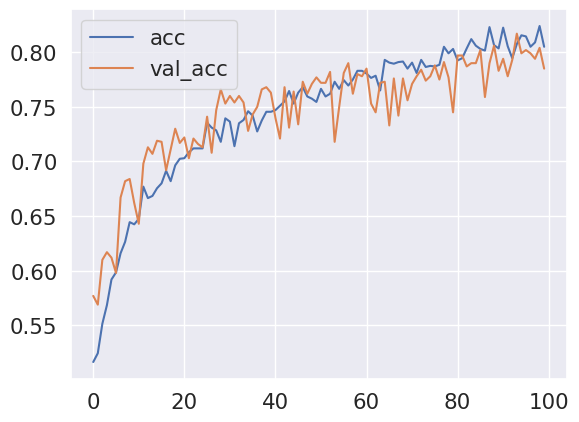

In [94]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['acc', 'val_acc']].plot()


test_loss, test_acc = model.evaluate(validation_generator, steps=50)
print('Test accuracy:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 87ms/step


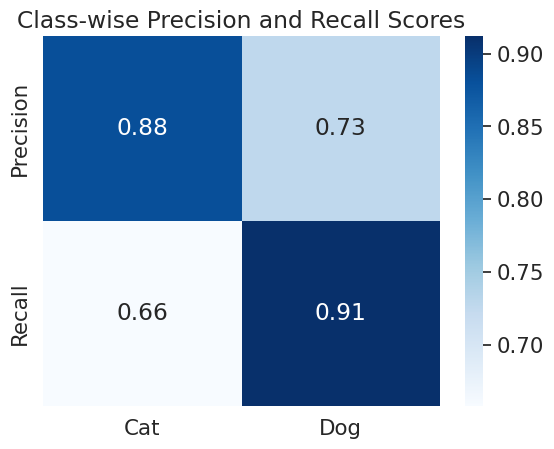

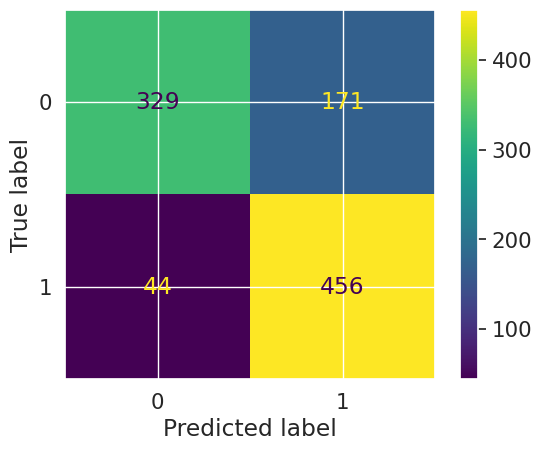

In [86]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns


test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = 'test'
test_generator = test_datagen.flow_from_directory(
         'cats_and_dogs_filtered/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical',
        shuffle = False)

# Get the predicted classes for the test data
y_pred_prob = model.predict(test_generator)
y_pred = np.round(y_pred_prob)

# Get the true classes for the test data
y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate precision and recall scores for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

# Create a heatmap plot of class-wise precision and recall scores
sns.set(font_scale=1.4)
sns.heatmap([precision, recall], annot=True, cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Precision', 'Recall'])
plt.title('Class-wise Precision and Recall Scores')
plt.show()

cm_display = ConfusionMatrixDisplay(cm).plot()

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import load_model


# Load the saved model
model = tf.keras.models.load_model('Assets_Modell/cats_dogs_classifier_80%.h5')

# Load the image and resize to the target size
img_path = 'cats_and_dogs_filtered/validation/dogs/dog.2013.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Convert the image to a numpy array and normalize
img_array = image.img_to_array(img)
img_array /= 255.

# Expand the dimensions of the image array to match the model input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict the class of the image
pred = model.predict(img_array)
pred_probability = pred[0][0]

if pred[0][0] > 0.5:
    print("The image is a dog with a probability of {:.2f}%".format(pred_probability * 100))
else:
    print("The image is a cat with a probability of {:.2f}%".format(pred_probability * 100))

1/1 [==============================] - 0s 61ms/step
The image is a dog with a probability of 93.10%


## Nur für mich - speichern und upload des Modells !!

In [48]:
import pandas as pd

history_df = pd.DataFrame(model.history.history)
history_df.to_csv('train_history_80%.csv', index=False)
model.save('cats_dogs_classifier_80%.h5')

In [90]:
from google.colab import drive
import shutil
import zipfile

drive.mount('/content/drive')
with zipfile.ZipFile('model.zip', 'w',
                     compression=zipfile.ZIP_DEFLATED,
                     compresslevel=9) as zf:
    zf.write('/content/cats_dogs_classifier_80%.h5', arcname='cats_dogs_classifier_80%.h5')

shutil.copy("/content/cats_dogs_classifier_80%.h5","/content/drive/MyDrive/MachineLearning")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
